In [1]:
import mdtraj as md
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from itertools import chain


In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

sns.set_style("whitegrid")


In [4]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


In [5]:
def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)


In [6]:
# Functions to Calculate Aromatic Stacking Interactions
from __future__ import print_function, division
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles


def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    print(np.shape(length), np.shape(centers), np.shape(normals))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return


In [7]:
outdir = './R2_R3_CYE/'
pdb = './trajectory/Tau5R2R3_CYE.pdb'
rep0 = './trajectory/Tau5R2R3_CYE.xtc'
helixpdb = './trajectory/R2R3_all_helix.pdb'

# Define Aromatic Rings in EPI-002
ligand_rings = [[200, 201, 202, 203, 211, 212], [193, 194, 195, 196, 213, 214]]
# Definie Hydrogen Bond Donors in EPI-002
lig_hbond_donors = [[210, 235], [208, 232], [190, 217]]

# Simulation Length in microseconds
sim_length = 4.0
print("outdir:", outdir)
print("pdb:", pdb)
print("helix pdb:", helixpdb)
print("trjaectory:", rep0)

# Make the outdir if it doesn't exist
if not os.path.exists(outdir):
    os.makedirs(outdir)


outdir: ./R2_R3_CYE/
pdb: ./trajectory/Tau5R2R3_CYE.pdb
helix pdb: ./trajectory/R2R3_all_helix.pdb
trjaectory: ./trajectory/Tau5R2R3_CYE.xtc


In [8]:
trj = md.load(rep0, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames


In [9]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 58
residue_offset = 390
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)


** SYSTEM INFO **

Number of atoms: 791

Number of residues: 58

Number of protein residues: 56

Number of frames: 59747

Starting frame: 0

Last frame: 59747

sequence:  [ACE0, LEU1, ASP2, TYR3, GLY4, SER5, ALA6, TRP7, ALA8, ALA9, ALA10, ALA11, ALA12, GLN13, CYE14, ARG15, TYR16, GLY17, ASP18, LEU19, ALA20, SER21, LEU22, HIS23, GLY24, ALA25, GLY26, ALA27, ALA28, GLY29, PRO30, GLY31, SER32, GLY33, SER34, PRO35, SER36, ALA37, ALA38, ALA39, SER40, SER41, SER42, TRP43, HIS44, THR45, LEU46, PHE47, THR48, ALA49, GLU50, GLU51, GLY52, GLN53, LEU54, TYR55, GLY56, NH257]

residue names:  ['ACE', 'LEU', 'ASP', 'TYR', 'GLY', 'SER', 'ALA', 'TRP', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'GLN', 'CYE', 'ARG', 'TYR', 'GLY', 'ASP', 'LEU', 'ALA', 'SER', 'LEU', 'HIS', 'GLY', 'ALA', 'GLY', 'ALA', 'ALA', 'GLY', 'PRO', 'GLY', 'SER', 'GLY', 'SER', 'PRO', 'SER', 'ALA', 'ALA', 'ALA', 'SER', 'SER', 'SER', 'TRP', 'HIS', 'THR', 'LEU', 'PHE', 'THR', 'ALA', 'GLU', 'GLU', 'GLY', 'GLN', 'LEU', 'TYR', 'GLY', 'NH2']

residue

In [10]:
# atom_Cl = top.select('resname LIG and name CL')
# atom_cys = top.select('name SG')
# # print(atom_Cl,atom_cys)
# # print('All atoms: %s' % [atom for atom in top.atoms])
# dist = md.compute_distances(trj, [[atom_Cl[0], atom_cys[0]]])
# dist_1d = list(chain.from_iterable(dist))
# array = np.asarray(dist_1d).astype(float)
# sns.kdeplot(data = array, label = 'CYS404:S - EPI-002:Cl')
# plt.xlabel('Distance (nm)', fontsize=18)
# plt.ylabel('Probability', fontsize=18)
# plt.ylim(0, 0.34)
# plt.legend(loc='upper right',fontsize=14)
# plt.tick_params(labelsize=18)

# plt.tight_layout()
# plt.savefig(outdir+'CL-S.histogram.png')
# np.savetxt(outdir+'CL-S.distance.dat',array)

/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


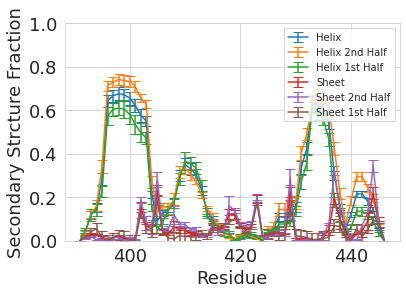

In [11]:
trjH1 = md.load(rep0, top=pdb, stride=1)
H1 = top.select("resid 1 to 56")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames
half = int(np.floor(frames/2))

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 390
hres_renum = np.asarray(h_res)+residue_offset


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)
dsspH1_h2 = md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1 = md.compute_dssp(trjH1[0:half], simplified=True)

H1_H, H1_E = dssp_convert(dsspH1)
H1_H_h2, H1_E_h2 = dssp_convert(dsspH1_h2)
H1_H_h1, H1_E_h1 = dssp_convert(dsspH1_h1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(
    hres_renum, H1_H_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Helix 2nd Half')
plt.errorbar(
    hres_renum, H1_H_h1[:, 0], yerr=H1_H_h1[:, 1], capsize=5, label='Helix 1st Half')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.errorbar(
    hres_renum, H1_E_h1[:, 0], yerr=H1_E_h1[:, 1], capsize=5, label='Sheet 2nd Half')
plt.errorbar(
    hres_renum, H1_E_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Sheet 1st Half')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


In [12]:
dsspH = np.copy(dsspH1)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH

print("Values for All Frames - Not Partitioned into Bound and Unbound")
print("Average Helical Residues:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/56.0))


Values for All Frames - Not Partitioned into Bound and Unbound
Average Helical Residues:13.605 +_ 0.412
Average Fraction Helix: 0.243 +_ 0.007


In [13]:
# Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label = []
for i_phi in range(0, indices_phi.shape[0]):
    resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
    phi_label.append(resindex)
phi_label = np.array(phi_label)
psi_label = []
for i_psi in range(0, indices_psi.shape[0]):
    resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
    psi_label.append(resindex)
psi_label = np.array(psi_label)
phipsi = []
for i in range(0, len(psi_label)-1):
    current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
    phipsi.append(current_phipsi)
phipsi_array = np.array(phipsi)


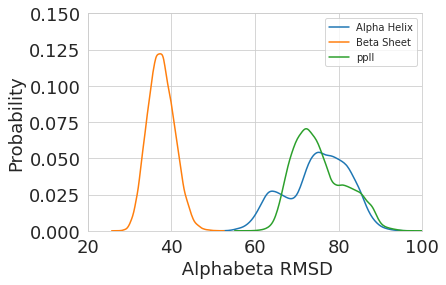

<Figure size 432x288 with 0 Axes>

In [14]:
def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
plt.xlim(20, 100)
plt.ylim(0, 0.15)

plt.ylabel('Probability', fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()
plt.savefig(outdir+'Alphabeta.histogram.png')


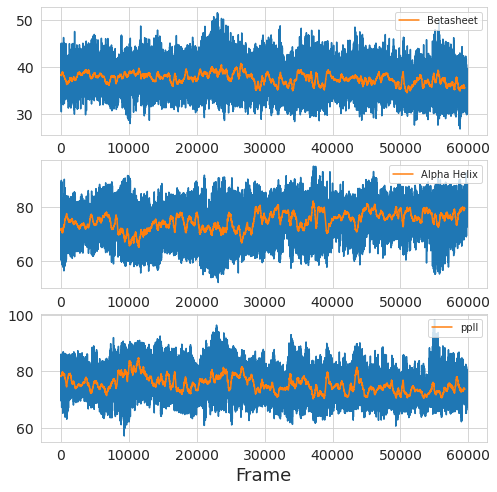

In [15]:
fig, ax = plt.subplots(3, figsize=((8, 8)))
N = 300
ax[0].plot(alphabeta_betasheet)
ax[0].plot(np.convolve(alphabeta_betasheet, np.ones(
    N)/N, mode='valid'), label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight, np.ones(
    N)/N, mode='valid'), label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(alphabeta_ppII)
ax[2].plot(np.convolve(alphabeta_ppII, np.ones(
    N)/N, mode='valid'), label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)

plt.xlabel('Frame', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png')


CA Radius of Gyration: 1.231 +_ 0.011
1st Half CA Radius of Gyration: 1.225 +_ 0.011
2nd Half CA Radius of Gyration: 1.238 +_ 0.012


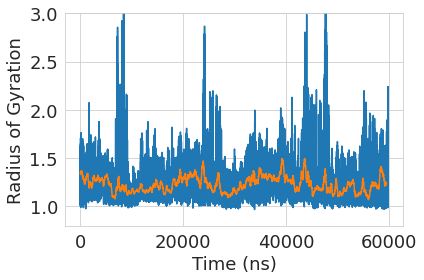

In [16]:
mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
# calculate CA radius of gyration
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
# SE_rg=(block(rg_all))**.5
plt.clf()
plt.plot(rg_CA)
plt.plot(np.convolve(rg_CA, np.ones(N)/N, mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.ylim(0.8, 3.0)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf" %
      np.average(rg_CA), "+_%6.3lf" % block(rg_CA)**.5)
print("1st Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[0:half]), "+_%6.3lf" % block(rg_CA[0:half])**.5)
print("2nd Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[half:-1]), "+_%6.3lf" % block(rg_CA[half:-1])**.5)

plt.savefig(outdir+'rg.pdf')
np.savetxt(outdir+'rg.dat', rg_CA)


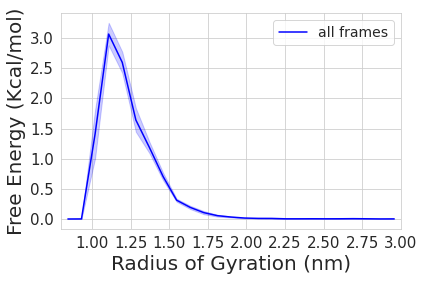

In [17]:
Rg_all, edges, u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_all, c='blue', label='all frames')
plt.fill_between(edges, Rg_all-u_err, Rg_all+u_err, color='blue', alpha=0.2)

plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


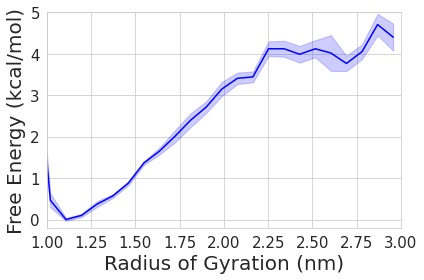

In [18]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


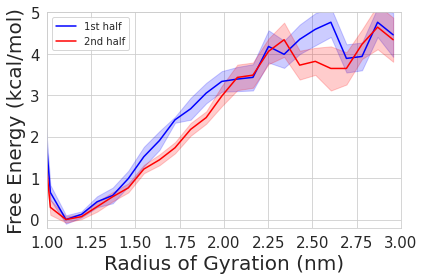

In [19]:
# [0:half],[half:-1]
dG1, bin_centers, ferr1 = free_energy_1D_blockerror(
    rg_CA[0:half], 300, 0.8, 3.0, 25, 5)
dG2, bin_centers, ferr2 = free_energy_1D_blockerror(
    rg_CA[half:-1], 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue', label='1st half')
sns.lineplot(x=bin_centers, y=dG2, color='red', label='2nd half')

plt.fill_between(bin_centers, dG1-ferr1, dG1+ferr1, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr2, dG2+ferr2, color='red', alpha=0.2)

plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.legend()
plt.tight_layout()
plt.tight_layout()
plt.savefig('%s/Rg.dG.splithalfs.pdf' % outdir)
plt.show()


Number of residues: 58

S$\alpha$: 7.191 +_ 0.290


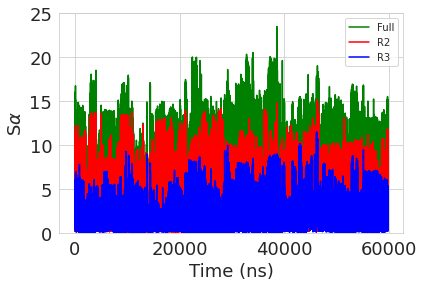

In [20]:
helixBB = md.load_pdb(helixpdb)
trjBB = md.load(rep0, top=pdb, stride=1)
BB = trjBB.topology.select("name CA")
HBB = helixBB.topology.select("name CA")

trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)
trjBB.center_coordinates()
helixBB.center_coordinates()

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 1
RMS_stop = 51
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = helixBB.topology.select("residue %s to %s and backbone" % (i, i+6))
    rmsd = md.rmsd(trjBB, helixBB, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)
Sa_R2 = np.sum(Sa[0:25], axis=0)
Sa_R3 = np.sum(Sa[36:56], axis=0)

print(r'S$\alpha$' + ":%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 300
plt.plot(Sa_total, label='Full', c='g')
plt.plot(Sa_R2, label='R2', c='r')
plt.plot(Sa_R3, label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel(r'S$\alpha$', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat', Sa_total)
np.savetxt(outdir+'Sa_total.R2.dat', Sa_R2)
np.savetxt(outdir+'Sa_total.R3.dat', Sa_R3)


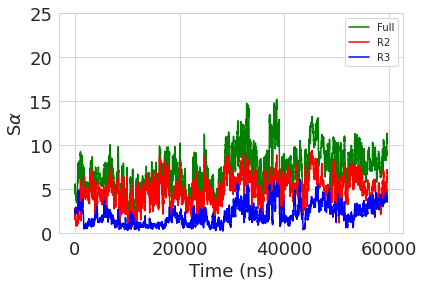

In [21]:
N = 100
plt.plot(np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
plt.plot(np.convolve(Sa_R2, np.ones(N)/N, mode='valid'), label='R2', c='r')
plt.plot(np.convolve(Sa_R3, np.ones(N)/N, mode='valid'), label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel(r'S$\alpha$', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.smooth.png')


**All Frames- Not Partitioned into Bound and Unbound**


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


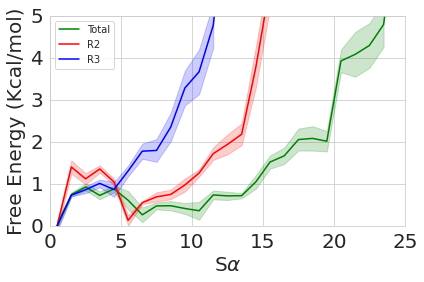

In [22]:
print("**All Frames- Not Partitioned into Bound and Unbound**")
Sa_dg, edges, Sa_err = free_energy_1D_blockerror(Sa_total, 300, 0, 25, 25, 5)
Sa2_dg, edges, Sa2_err = free_energy_1D_blockerror(Sa_R2, 300, 0, 25, 25, 5)
Sa3_dg, edges, Sa3_err = free_energy_1D_blockerror(Sa_R3, 300, 0, 25, 25, 5)

plt.clf()
plt.plot(edges, Sa_dg, c='g', label='Total')
plt.plot(edges, Sa2_dg, c='r', label='R2')
plt.plot(edges, Sa3_dg, c='b', label='R3')
plt.fill_between(edges, Sa_dg-Sa_err, Sa_dg+Sa_err, color='g', alpha=0.2)
plt.fill_between(edges, Sa2_dg-Sa2_err, Sa2_dg+Sa2_err, color='r', alpha=0.2)
plt.fill_between(edges, Sa3_dg-Sa3_err, Sa3_dg+Sa3_err, color='b', alpha=0.2)

plt.legend()

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel(r'S$\alpha$', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
np.savetxt(outdir+'Sa_dg.dat', np.column_stack((edges, Sa_dg, Sa_err)))
np.savetxt(outdir+'Sa.R2dg.dat', np.column_stack((edges, Sa2_dg, Sa2_err)))
np.savetxt(outdir+'Sa.R3.dg.dat', np.column_stack((edges, Sa3_dg, Sa3_err)))
plt.savefig('%s/Sa.dG.png' % outdir)


In [23]:
print("**All Frames- Not Partitioned into Bound and Unbound**")
rg_v_Sa = np.column_stack((rg_CA, Sa_total))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]
Sa_cutoff = 6.0
helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
glob_index = np.intersect1d(collapsed, helical)
rg_v_Sa[glob_index]
globule_pop = len(glob_index)/len(rg_v_Sa)
print("Ensemble Globule Pop:", globule_pop, "Non Globule:", 1-globule_pop)
T = 300
glob_rg, glob_rg_be = get_blockerror_pyblock(rg_v_Sa[glob_index][:, 0])
rg, rg_be = get_blockerror_pyblock(rg_v_Sa[:, 0])
print("Rg:", rg, "+_", rg_be)
print("Globule Rg:", glob_rg, "+_", glob_rg_be)

T = 300
print("Free Energy Globule:", -(0.001987*T)*np.log(globule_pop))
print("Free Energy Non-Globule:", -(0.001987*T)*np.log(1-globule_pop))
print("Free Energy Difference:", -(0.001987*T)
      * np.log(globule_pop/(1-globule_pop)))


glob_binary = np.zeros(len(rg_v_Sa))
glob_binary[glob_index] = 1
glob_frac = len(glob_index)/len(glob_binary)
glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
print("Globule Fraction:", glob_boundfrac, "+_", glob_boundfrac_be)
glob_upper = glob_boundfrac+glob_boundfrac_be
non_glob = 1-glob_boundfrac
non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
print("Non Globule Fraction:", 1-glob_boundfrac, "+_", glob_boundfrac_be)
dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                      glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
print("Free Energy Difference:", dG_diff, "+_", dG_diff-dG_diff_upper)


**All Frames- Not Partitioned into Bound and Unbound**
Ensemble Globule Pop: 0.5227710177916883 Non Globule: 0.47722898220831167
Rg: 1.2310848249581492 +_ 0.011714265358407888
Globule Rg: 1.1311030981377943 +_ 0.008009506749422713
Free Energy Globule: 0.3866374554006587
Free Energy Non-Globule: 0.440970254491375
Free Energy Difference: -0.05433279909071629
Globule Fraction: 0.5227710177916883 +_ 0.03247069517376464
Non Globule Fraction: 0.47722898220831167 +_ 0.03247069517376464
Free Energy Difference: -0.05433279909071629 +_ 0.07792544489496211


In [24]:
contact_maps = []
contact_distances = []
for i in range(1, 57):
    contact_map = []
    contact_distance = []
    for j in range(1, 57):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


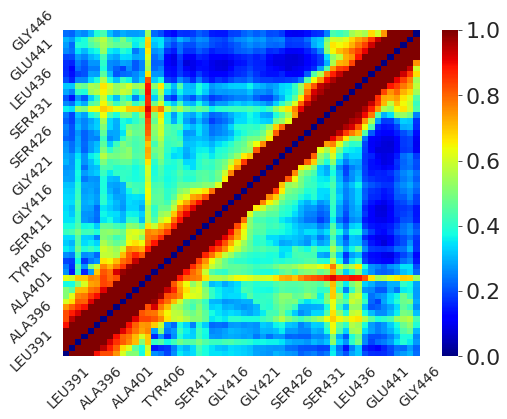

In [25]:
contact_map = final_map
sequence = ['LEU391', '', '', '', '', 'ALA396', '', '', '', '', 'ALA401', '', '', '', '', 'TYR406', '', '', '', '', 'SER411', '', '', '', '', 'GLY416',
            '', '', '', '', 'GLY421', '', '', '', '', 'SER426', '', '', '', '', 'SER431', '', '', '', '', 'LEU436', '', '', '', '', 'GLU441', '', '', '', '', 'GLY446']

# Make distance map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(1, 57), sequence, rotation=45, size=14)
plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()


np.savetxt(outdir+'contactmap.dat', final_map)
plt.savefig(outdir+'contact_map.png')
plt.savefig(outdir+'contact_map.pdf')
plt.show()


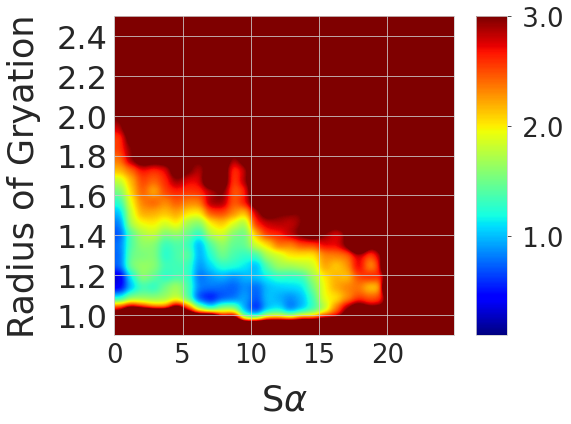

In [26]:
a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel(r'S$\alpha$', size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.dG.allframes.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.allframes.pdf')


<Figure size 432x288 with 0 Axes>

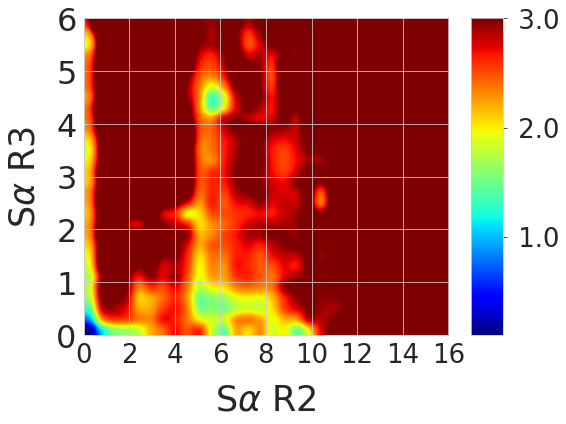

In [27]:
dG, xedges, yedges = free_energy(Sa_R3, Sa_R2, 300, 0, 6.0, 0, 16.0)

# a,xedges,yedges=np.histogram2d(Sa_total_H2,Sa_total_H1,35,[[0,3.5],[0,12]],normed=True,weights=None)
# a=np.log(np.flipud(a)+.000001)
# T=300
# a=-(0.001987*T)*a

plt.clf()
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel(r'S$\alpha$' + " R3", size=35, labelpad=15)
plt.xlabel(r'S$\alpha$' + " R2", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

plt.tight_layout()
np.savetxt(outdir+'SaR3_v_SaR2.dg.allframes.dat', dG)
plt.savefig(outdir+'R2_v_R3.allframes.pdf')


In [28]:
# Select Ligand Residues
ligand = top.select("residue 58")
# Select Protein Residues
protein = top.select("residue 0 to 57")

ligand_atomid = []
for atom in ligand:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    ligand_atomid.append(indices)


protein_atomid = []
for atom in protein:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    protein_atomid.append(indices)

print(ligand_atomid)
print(protein_atomid)


[]
[[0, ACE0-H1], [1, ACE0-CH3], [2, ACE0-H2], [3, ACE0-H3], [4, ACE0-C], [5, ACE0-O], [6, LEU1-N], [7, LEU1-H], [8, LEU1-CA], [9, LEU1-HA], [10, LEU1-CB], [11, LEU1-HB3], [12, LEU1-HB2], [13, LEU1-CG], [14, LEU1-HG], [15, LEU1-CD1], [16, LEU1-HD11], [17, LEU1-HD12], [18, LEU1-HD13], [19, LEU1-CD2], [20, LEU1-HD21], [21, LEU1-HD22], [22, LEU1-HD23], [23, LEU1-C], [24, LEU1-O], [25, ASP2-N], [26, ASP2-H], [27, ASP2-CA], [28, ASP2-HA], [29, ASP2-CB], [30, ASP2-HB3], [31, ASP2-HB2], [32, ASP2-CG], [33, ASP2-OD1], [34, ASP2-OD2], [35, ASP2-C], [36, ASP2-O], [37, TYR3-N], [38, TYR3-H], [39, TYR3-CA], [40, TYR3-HA], [41, TYR3-CB], [42, TYR3-HB3], [43, TYR3-HB2], [44, TYR3-CG], [45, TYR3-CD1], [46, TYR3-HD1], [47, TYR3-CE1], [48, TYR3-HE1], [49, TYR3-CZ], [50, TYR3-OH], [51, TYR3-HH], [52, TYR3-CE2], [53, TYR3-HE2], [54, TYR3-CD2], [55, TYR3-HD2], [56, TYR3-C], [57, TYR3-O], [58, GLY4-N], [59, GLY4-H], [60, GLY4-CA], [61, GLY4-HA3], [62, GLY4-HA2], [63, GLY4-C], [64, GLY4-O], [65, SER5-N], [6

Fraction Bound: 1.0


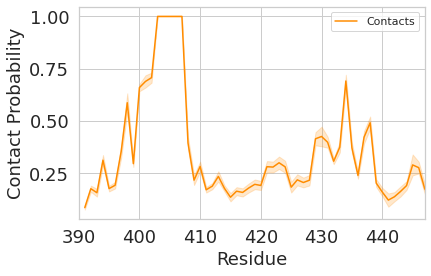

<Figure size 432x288 with 0 Axes>

In [29]:
residues = 58
residue_offset = 390
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

# Calculate Contact Probabilities between each protein residue and the ligand
#residue_number = range(residue_offset, residue_offset+residues)
contact_pairs = np.zeros((residues, 2))
ligand_residue_index = 14

for i in range(0, residues):
    contact_pairs[i] = [i, ligand_residue_index]
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
contacts = np.asarray(contact[0]).astype(float)
cutoff = 0.6
contact_matrix = np.where(contacts < cutoff, 1, 0)
contact_prob = np.sum(contact_matrix, axis=0)/trj.n_frames
np.savetxt(outdir+'contacts.traj.dat', contact_matrix, '%i')


contact_rows = np.sum(contact_matrix, axis=1)
contact_frames = np.where(contact_rows > 0)[0]
nocontact_frames = np.where(contact_rows == 0)[0]
contact_fraction = np.sum(np.where(contact_rows > 0, 1, 0))/len(contact_rows)
print("Fraction Bound:", contact_fraction)

# Total Contacts with errors
contact_ave, contact_pyb_be = get_blockerrors_pyblock(contact_matrix, 1.0)
contact_ave, contact_pyb_be_max = get_blockerrors_pyblock(contact_matrix, 1.0)

resnum = np.linspace(391, 448, num=58)
contact_be = np.column_stack((resnum, contact_ave, contact_pyb_be))
contact_be_max = np.column_stack((resnum, contact_ave, contact_pyb_be_max))

np.savetxt('%s/contact.be.pyblock.dat' % outdir, contact_be, '%.4f')
np.savetxt('%s/contact.be.pyblock.max.dat' % outdir, contact_be_max, '%.4f')
sns.set(style='whitegrid')

Contact = contact_be
sns.lineplot(x=Contact[:, 0], y=Contact[:, 1],
             color='darkorange', label='Contacts')
plt.fill_between(Contact[:, 0], Contact[:, 1]+Contact[:, 2],
                 Contact[:, 1]-Contact[:, 2], color='darkorange', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.tight_layout()
plt.savefig(outdir+'ContactFraction.byResidue.ClosestHeavy.png')
plt.show()
plt.ylim(0, 0.5)
plt.clf()


In [30]:
Box_L = trj.unitcell_lengths[0][0]
# Convert nM to meters for Box_V in M^3
Box_V = (Box_L*10**-9)**3
# Convert Box_V to L
Box_V_L = Box_V*1000
#Concentraion in Mols/L
Concentration = 1/(Box_V_L*(6.023*10**23))
print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)

contact_binary = np.where(contact_rows > 0, 1, 0)
boundfrac, boundfrac_be = get_blockerror_pyblock(contact_binary)
print("Bound Fraction:", boundfrac, "+_", boundfrac_be)
upper = boundfrac+boundfrac_be
KD = Kd_calc(boundfrac, Concentration)
KD_upper = Kd_calc(upper, Concentration)
KD_error = KD-KD_upper
print("KD (mM):", KD*1000, "+_", KD_error*1000)


L: 7.5 V: 4.218750000000002e-25 Conc: 0.003935531081471642
Bound Fraction: 1.0 +_ 0.0
KD (mM): 0.0 +_ 0.0


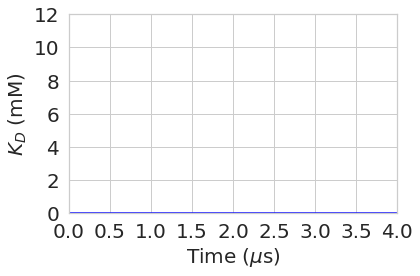

In [31]:
# Time Series of KD Calculations
time = np.linspace(0, sim_length, len(contact_binary))
boundfrac_by_frame = []
t2 = []
err_by_frame = []
err_upper = []
err_lower = []
stride = 100

for i in range(stride, len(contact_binary), stride):
    Data = np.asarray(contact_binary[0:i])
    bf, be = get_blockerror_pyblock_nanskip(Data)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(be)
    err_upper.append(bf-be)
    err_lower.append(bf+be)
    t2.append(time[i])

Kd = Kd_calc(np.asarray(boundfrac_by_frame), Concentration)*1000
Kd_upper = Kd_calc(np.asarray(err_upper), Concentration)*1000
Kd_lower = Kd_calc(np.asarray(err_lower), Concentration)*1000
np.savetxt('%s/KD.timecourse.errors.dat' %
           (outdir), np.column_stack((t2, Kd, Kd_upper, Kd_lower)), '%.4f')

# KD_upper=err_upper
plt.plot(t2, Kd, color='blue')
plt.fill_between(t2, Kd_upper, Kd_lower, color='blue', alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time ($\mu$s)', fontsize=20)
plt.ylabel('$K_D$ (mM)', fontsize=20)
plt.grid(True)
plt.ylim(0, 12.0)
plt.xlim(0, sim_length)
plt.tight_layout()
plt.savefig(outdir+'KD.bytime.blockerrors.pdf', bbox_inches='tight')


In [32]:
rg_v_Sa = np.column_stack((rg_CA[contact_frames], Sa_total[contact_frames]))
print(len(rg_v_Sa))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]
Sa_cutoff = 6.0
helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
glob_index = np.intersect1d(collapsed, helical)
globule_pop = len(glob_index)/len(rg_v_Sa)

print("Ensemble Globule Pop:", globule_pop, "Non Globule:", 1-globule_pop)
glob_rg, glob_rg_be = get_blockerror_pyblock(rg_v_Sa[glob_index][:, 0])
rg, rg_be = get_blockerror_pyblock(rg_v_Sa[:, 0])
print("Rg:", rg, "+_", rg_be)
print("Globule Rg:", glob_rg, "+_", glob_rg_be)

T = 300
print("Free Energy Globule:", -(0.001987*T)*np.log(globule_pop))
print("Free Energy Non-Globule:", -(0.001987*T)*np.log(1-globule_pop))
print("Free Energy Difference:", -(0.001987*T)
      * np.log(globule_pop/(1-globule_pop)))


glob_binary = np.zeros(len(rg_v_Sa))
glob_binary[glob_index] = 1
glob_frac = len(glob_index)/len(glob_binary)
glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
print("Bound Globule Fraction:", glob_boundfrac, "+_", glob_boundfrac_be)
glob_upper = glob_boundfrac+glob_boundfrac_be
non_glob = 1-glob_boundfrac
non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
print("Non Globule Fraction:", 1-glob_boundfrac, "+_", glob_boundfrac_be)
dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                      glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
print("Free Energy Difference:", dG_diff, "+_", dG_diff-dG_diff_upper)


59747
Ensemble Globule Pop: 0.5227710177916883 Non Globule: 0.47722898220831167
Rg: 1.2310848249581492 +_ 0.011714265358407888
Globule Rg: 1.1311030981377943 +_ 0.008009506749422713
Free Energy Globule: 0.3866374554006587
Free Energy Non-Globule: 0.440970254491375
Free Energy Difference: -0.05433279909071629
Bound Globule Fraction: 0.5227710177916883 +_ 0.03247069517376464
Non Globule Fraction: 0.47722898220831167 +_ 0.03247069517376464
Free Energy Difference: -0.05433279909071629 +_ 0.07792544489496211


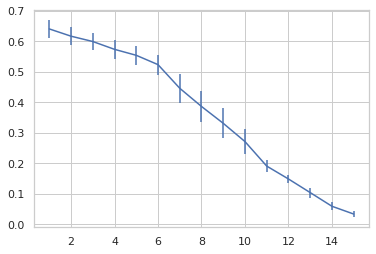

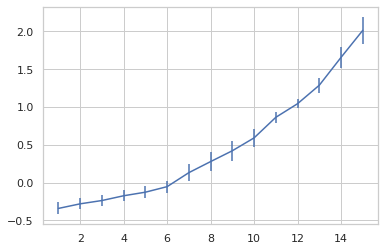

In [33]:
Sa_cut = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
glob_pops = []
glob_errs = []
glob_dGs = []
glob_dGs_err = []

rg_v_Sa = np.column_stack((rg_CA[contact_frames], Sa_total[contact_frames]))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]

for i in Sa_cut:
    Sa_cutoff = i
    helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
    glob_index = np.intersect1d(collapsed, helical)
    globule_pop = len(glob_index)/len(rg_v_Sa)
    T = 300
    glob_binary = np.zeros(len(rg_v_Sa))
    glob_binary[glob_index] = 1
    glob_frac = len(glob_index)/len(glob_binary)
    glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
    glob_upper = glob_boundfrac+glob_boundfrac_be
    non_glob = 1-glob_boundfrac
    non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
    dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
    dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                          glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
    glob_pops.append(globule_pop)
    glob_errs.append(glob_boundfrac_be)
    glob_dGs.append(dG_diff)
    glob_dGs_err.append(dG_diff-dG_diff_upper)

plt.errorbar(Sa_cut, glob_pops, yerr=glob_errs)
plt.show()
plt.clf()
plt.errorbar(Sa_cut, glob_dGs, yerr=glob_dGs_err)
plt.show()

np.savetxt(outdir+'Pop.vs.Sacut.dat',
           np.column_stack((Sa_cut, glob_pops, glob_errs)))
np.savetxt(outdir+'dGglob.vs.Sacut.dat',
           np.column_stack((Sa_cut, glob_dGs, glob_dGs_err)))


In [34]:
rg_v_Sa = np.column_stack((rg_CA, Sa_total))
print(len(rg_v_Sa))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]
Sa_cutoff = 6.0
helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
glob_index = np.intersect1d(collapsed, helical)
glob_binary = np.zeros(len(rg_v_Sa))
glob_binary[glob_index] = 1
bound_frac, bound_frac_be = get_blockerror_pyblock(contact_binary)
glob_frac, glob_frac_be = get_blockerror_pyblock(glob_binary)

bound_glob_binary = np.zeros(len(rg_v_Sa))
bound_glob_frames = np.intersect1d(contact_frames, glob_index)
bound_glob_binary[bound_glob_frames] = 1
bound_glob_frac, boubd_glob_frac_be = get_blockerror_pyblock(bound_glob_binary)
print(bound_glob_frac, boubd_glob_frac_be)
print("Globule Fraction of Bound Frames:", bound_glob_frac /
      bound_frac, "+_", boubd_glob_frac_be/bound_frac)


59747
0.5227710177916883 0.03247069517376464
Globule Fraction of Bound Frames: 0.5227710177916883 +_ 0.03247069517376464


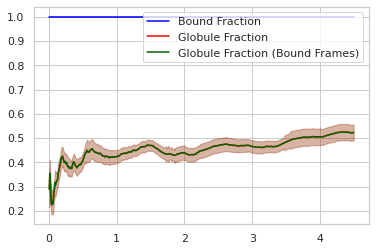

In [35]:
stride = 100
be_by_frame = []
ge_by_frame = []
boundfrac_by_frame = []
globfrac_by_frame = []
bg_pop = []
bg_pop2 = []
bge_by_frame = []
time = np.linspace(0, 4.5, len(contact_binary))
t = []

for i in range(stride, len(contact_binary), stride):
    c_Data = np.asarray(contact_binary[0:i])
    g_Data = np.asarray(glob_binary[0:i])
    frames = len(c_Data)
    bframes = np.where(c_Data == 1)[0]
    gframes = np.where(g_Data == 1)[0]
    bgframes = np.intersect1d(bframes, gframes)
    bg_binary = np.zeros(frames)
    bg_binary[bgframes] = 1
    bgf, bge = get_blockerror_pyblock_nanskip(bg_binary)
    bg_pop.append(len(bgframes)/len(bframes))
    bf, be = get_blockerror_pyblock_nanskip(c_Data)
    gf, ge = get_blockerror_pyblock_nanskip(g_Data)
    bg_pop2.append(bgf/bf)
    bge_by_frame.append(bge/bf)
    boundfrac_by_frame.append(bf)
    globfrac_by_frame.append(gf)
    be_by_frame.append(be)
    ge_by_frame.append(ge)
    t.append(time[i])
np.savetxt(outdir+'glob.frac.be.dat',
           np.column_stack((globfrac_by_frame, ge_by_frame)))

plt.plot(t, boundfrac_by_frame, label='Bound Fraction', color='blue')
plt.plot(t, globfrac_by_frame, label='Globule Fraction', color='red')
plt.plot(t, bg_pop2, label='Globule Fraction (Bound Frames)', color='darkgreen')
plt.fill_between(t, np.asarray(bg_pop2)+np.asarray(bge_by_frame),
                 np.asarray(bg_pop2)-np.asarray(bge_by_frame), color='darkgreen', alpha=0.2)
plt.fill_between(t, np.asarray(globfrac_by_frame)+np.asarray(ge_by_frame),
                 np.asarray(globfrac_by_frame)-np.asarray(ge_by_frame), color='red', alpha=0.2)
plt.fill_between(t, np.asarray(boundfrac_by_frame)+np.asarray(be_by_frame),
                 np.asarray(boundfrac_by_frame)-np.asarray(be_by_frame), color='blue', alpha=0.2)
plt.legend(loc='upper right')


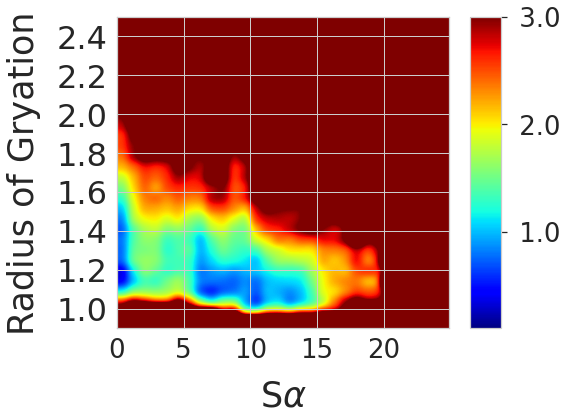

In [36]:
a, xedges, yedges = np.histogram2d(rg_CA[contact_frames], Sa_total[contact_frames], 30, [
                                   [0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlim(0, 24.9)
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel(r'S$\alpha$', size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.ligand_contacts.dG.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.ligand_contacts.pdf')


<Figure size 432x288 with 0 Axes>

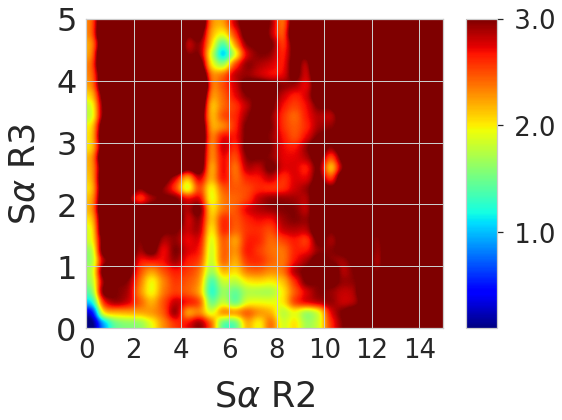

In [37]:
dG, xedges, yedges = free_energy(
    Sa_R3[contact_frames], Sa_R2[contact_frames], 300, 0, 5.0, 0, 15.0)

# a,xedges,yedges=np.histogram2d(Sa_total_H2,Sa_total_H1,35,[[0,3.5],[0,12]],normed=True,weights=None)
# a=np.log(np.flipud(a)+.000001)
# T=300
# a=-(0.001987*T)*a

plt.clf()
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel(r'S$\alpha$' + " R3", size=35, labelpad=15)
plt.xlabel(r'S$\alpha$' + " R2", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()
np.savetxt(outdir+'Sa2_v_Sa3.lig_contacts.dG.dat', dG)
plt.savefig(outdir+'Sa2_v_Sa3.dG.lig_contacts.pdf')


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/numpy/lib/histograms.py:1118: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


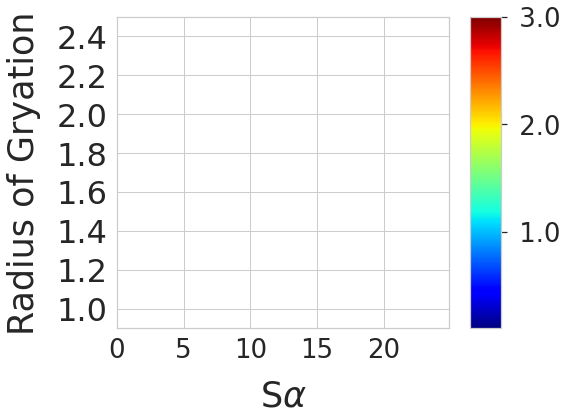

In [38]:
a, xedges, yedges = np.histogram2d(rg_CA[nocontact_frames], Sa_total[nocontact_frames], 30, [
                                   [0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlim(0, 24.9)

plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel(r'S$\alpha$', size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.unbound.dG.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.unbound.pdf')


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/numpy/lib/histograms.py:1118: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


<Figure size 432x288 with 0 Axes>

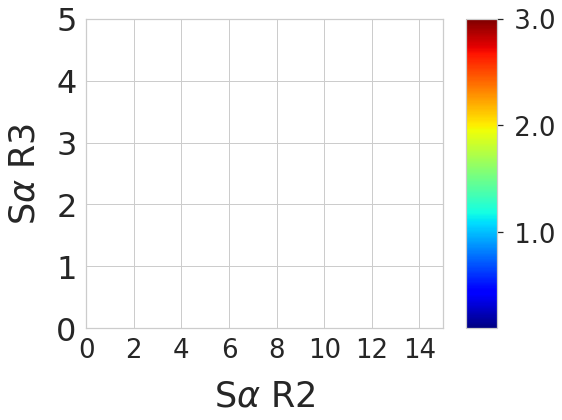

In [39]:
dG, xedges, yedges = free_energy(
    Sa_R3[nocontact_frames], Sa_R2[nocontact_frames], 300, 0, 5.0, 0, 15.0)

# a,xedges,yedges=np.histogram2d(Sa_total_H2,Sa_total_H1,35,[[0,3.5],[0,12]],normed=True,weights=None)
# a=np.log(np.flipud(a)+.000001)
# T=300
# a=-(0.001987*T)*a

plt.clf()
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel(r'S$\alpha$' + " R3", size=35, labelpad=15)
plt.xlabel(r'S$\alpha$' + " R2", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()
np.savetxt(outdir+'Sa2_v_Sa3.unbound.dG.dat', dG)
plt.savefig(outdir+'Sa2_v_Sa3.dG.unbound.pdf')


In [40]:
# dist = md.compute_distances(trj[contact_frames], [[atom_Cl[0], atom_cys[0]]])
# dist_1d = list(chain.from_iterable(dist))
# array = np.asarray(dist_1d).astype(float)
# sns.kdeplot(data = array, label = 'CYS404:S - EPI-002:Cl')
# plt.xlabel('Distance (nm)', fontsize=18)
# plt.ylabel('Probability', fontsize=18)
# # plt.ylim(0, 0.34)
# plt.legend(loc='upper right',fontsize=14)
# plt.tick_params(labelsize=18)

# plt.tight_layout()
# plt.savefig(outdir+'CL-S.histogram.bound.png')
# np.savetxt(outdir+'CL-S.distance.bound.dat',array)

/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Bound Average Helical Res:13.605 +_ 0.412
Bound Averagr Fraction Helix: 0.243 +_ 0.007


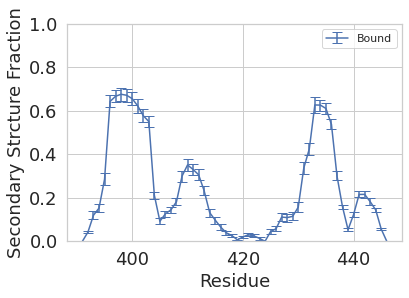

In [41]:
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock


dssp_bound = dsspH1[contact_frames]
dssp_unbound = dsspH1[nocontact_frames]
H1_H_bound, H1_E_bound = dssp_convert(dssp_bound)

plt.errorbar(hres_renum, H1_H_bound[:, 0],
             yerr=H1_H_bound[:, 1], capsize=5, label='Bound')


plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.bound.err.dat',
           np.column_stack((hres_renum, H1_H_bound[:, 0], H1_H_bound[:, 1])))
np.savetxt(outdir+'Eprop.bound.err.dat',
           np.column_stack((hres_renum, H1_E_bound[:, 0], H1_E_bound[:, 1])))


dsspH = np.copy(dssp_bound)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Bound Average Helical Res:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Bound Averagr Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/56.0))



In [42]:
def calc_err(contact_binary, name):
    boundfrac_by_frame = []
    t2 = []
    err_by_frame = []
    err_upper = []
    err_lower = []
    time = np.linspace(0, sim_length/len(Sa_total)*len(contact_binary), len(contact_binary))
    srtide = 100
    for i in range(stride, len(contact_binary), stride):
        Data = np.asarray(contact_binary[0:i])
        bf, be = get_blockerror_pyblock_nanskip(Data)
        boundfrac_by_frame.append(bf)
        err_by_frame.append(be)
        err_upper.append(bf-be)
        err_lower.append(bf+be)
        t2.append(time[i])
    np.savetxt(outdir + name, np.column_stack((t2, boundfrac_by_frame, err_upper, err_lower)), '%.4f')

calc_err(rg_CA, 'rg.be.dat')
calc_err(Sa_total, 'Sa.be.dat')

In [43]:
# Calculate Hydrophobic contacts
ligand_hphob = top.select("resid 14 and element C and not name CA CB C ")
protein_hphob = top.select("resid 0 to 13 or resid 15 to 57 and element C")


ligand_hphob_atoms = []
for atom in ligand_hphob:
    ligand_hphob_atoms.append(top.atom(atom))

protein_hphob_atoms = []
for atom in protein_hphob:
    protein_hphob_atoms.append(top.atom(atom))

print(ligand_hphob)
print(ligand_hphob_atoms)


def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob


hphob_pairs = []
for i in ligand_hphob:
    for j in protein_hphob:
        hphob_pairs.append([i, j])


contact = md.compute_distances(trj, hphob_pairs)
contacts = np.asarray(contact).astype(float)
cutoff = 0.4
contact_frames = np.where(contacts < cutoff, 1, 0)
contact_prob_hphob = np.sum(contact_frames, axis=0)/trj.n_frames


# Hphob Contacts at Atom Pair Resolution
hphob_pair_names = {}
for i in range(0, len(hphob_pairs)):
    a1_id = hphob_pairs[i][0]
    a2_id = hphob_pairs[i][1]
    a1 = top.atom(hphob_pairs[i][0])
    a2 = top.atom(hphob_pairs[i][1])
    prot_res = top.atom(hphob_pairs[i][1]).residue.resSeq
    add_contact_pair(hphob_pair_names, a1, a2, a1_id,
                     a2_id, prot_res, contact_prob_hphob[i])

#residue_number = range(residue_offset, residue_offset+residues)
hphob_max_contacts = {}

# Print Most Populated Contact For Each Aliphatic Carbon in the protein
for i in residue_number:
    if i in hphob_pair_names.keys():
        maxi = 0
        for j in hphob_pair_names[i]:
            max_contact_j = max(
                hphob_pair_names[i][j], key=hphob_pair_names[i][j].get)
            max_contact_fraction = hphob_pair_names[i][j][max_contact_j]
            if max_contact_fraction > maxi:
                max_key_j = j
                max_j_subkey = max_contact_j
                maxi = max_contact_fraction
        hphob_max_contacts[i] = [max_key_j, max_j_subkey, top.atom(
            max_j_subkey), hphob_pair_names[i][max_key_j][max_j_subkey]]


[187 188 191 193 194 195 196 197 198 199 200 201 202 203 205 206 209 211
 212 213 214]
[CYE14-C4, CYE14-C5, CYE14-C6, CYE14-C7, CYE14-C8, CYE14-C9, CYE14-C10, CYE14-C11, CYE14-C12, CYE14-C13, CYE14-C14, CYE14-C15, CYE14-C16, CYE14-C17, CYE14-C18, CYE14-C19, CYE14-C20, CYE14-C21, CYE14-C22, CYE14-C23, CYE14-C24]


[0.007 0.010 0.007 0.020 0.012 0.007 0.026 0.054 0.013 0.037 0.027 0.033
 0.018 0.041 0.000 0.013 0.023 0.004 0.004 0.009 0.006 0.005 0.017 0.007
 0.004 0.007 0.006 0.004 0.007 0.007 0.017 0.006 0.005 0.007 0.011 0.018
 0.015 0.013 0.012 0.007 0.007 0.005 0.013 0.043 0.023 0.009 0.013 0.025
 0.003 0.007 0.003 0.007 0.005 0.005 0.018 0.012 0.009 0.000]


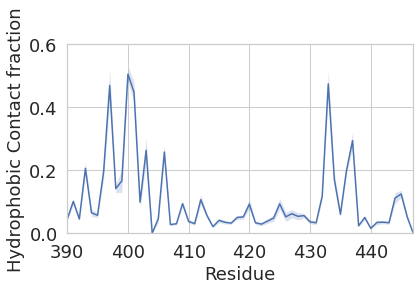

<Figure size 432x288 with 0 Axes>

In [44]:
# Cast hydrophobic contacts as per residue in each frame
Hphob_res_contacts = np.zeros((n_frames, residues))
for frame in range(n_frames):
    if np.sum(contact_frames[frame]) > 0:
        contact_pairs = np.where(contact_frames[frame] == 1)
        for j in contact_pairs[0]:
            residue = top.atom(hphob_pairs[j][1]).residue.resSeq
            Hphob_res_contacts[frame][residue] = 1


np.savetxt(outdir+'hphob_contacts.traj.dat', Hphob_res_contacts, '%i')
hphob_ave, hphob_pyb_be = get_blockerrors_pyblock(Hphob_res_contacts, 1.0)
print(hphob_pyb_be)
hphob_by_res = np.column_stack(
    (residue_number_offset, hphob_ave, hphob_pyb_be))
np.savetxt(outdir+'hphob_contacts.be.dat', hphob_by_res)

plt.plot(residue_number_offset, hphob_by_res[:, 1])
plt.fill_between(residue_number_offset,
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.6)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContactFraction.LigandCarbon.ProteinCarbon.pdf")
plt.show()
plt.clf()


hphob_by_res_boundfraction = np.column_stack(
    (residue_number, hphob_by_res[:, 1]/boundfrac, hphob_by_res[:, 2]/boundfrac))
np.savetxt(outdir+'hphob_contacts.BF.dat', hphob_by_res, fmt='%.4f')
plt.plot(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1])
plt.fill_between(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1] +
                 hphob_by_res_boundfraction[:, 2], hphob_by_res_boundfraction[:, 1]-hphob_by_res_boundfraction[:, 2], alpha=0.2)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.6)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContacts.BoundFraction.pdf")
plt.clf()


In [45]:
n_rings = len(ligand_rings)
print("Ligand Aromatics Rings:", n_rings)

ligand_ring_params = []
for i in range(0, n_rings):
    ring = np.array(ligand_rings[i])
    print(ring)
    positions = trj.xyz[:, ring, :]
    print(ligand_rings[i][0], ligand_rings[i][1], ligand_rings[i][2])
    ligand_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    ligand_ring_params.append(ligand_centers_normals)

prot_rings = []
aro_residues = []
prot_ring_name = []
prot_ring_index = []

aro_select = top.select("resname TYR PHE HIS TRP and name CA")
for i in aro_select:
    atom = top.atom(i)
    resname = atom.residue.name
    print(atom.index, atom.name, atom.residue.name,
          atom.residue, atom.residue.index)
    if resname == "TYR":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "TRP":
        ring = top.select(
            "resid %s and name CG CD1 NE1 CE2 CD2 CZ2 CE3 CZ3 CH2" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "HIS":
        ring = top.select("resid %s and name CG ND1 CE1 NE2 CD2" %
                          atom.residue.index)
        print(atom.residue, ring)
    if resname == "PHE":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    prot_rings.append(ring)
    prot_ring_name.append(atom.residue)
    prot_ring_index.append(atom.residue.index+residue_offset)


print("Protein Aromatics Rings:", len(prot_rings), prot_ring_name)

prot_ring_params = []
for i in range(0, len(prot_rings)):
    ring = np.array(prot_rings[i])
    positions = trj.xyz[:, ring, :]
    ring_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    prot_ring_params.append(ring_centers_normals)


Ligand Aromatics Rings: 2
[200 201 202 203 211 212]
200 201 202
() (59747, 3) (59747, 3)
[193 194 195 196 213 214]
193 194 195
() (59747, 3) (59747, 3)
39 CA TYR TYR3 3
TYR3 [44 45 47 49 52 54]
88 CA TRP TRP7 7
TRP7 [ 93  94  96  98  99 101 103 105 107]
266 CA TYR TYR16 16
TYR16 [271 272 274 276 279 281]
365 CA HIS HIS23 23
HIS23 [370 371 372 374 376]
571 CA TRP TRP43 43
TRP43 [576 577 579 581 582 584 586 588 590]
595 CA HIS HIS44 44
HIS44 [600 601 602 604 606]
645 CA PHE PHE47 47
PHE47 [650 651 653 655 657 659]
762 CA TYR TYR55 55
TYR55 [767 768 770 772 775 777]
Protein Aromatics Rings: 8 [TYR3, TRP7, TYR16, HIS23, TRP43, HIS44, PHE47, TYR55]
() (59747, 3) (59747, 3)
() (59747, 3) (59747, 3)
() (59747, 3) (59747, 3)
() (59747, 3) (59747, 3)
() (59747, 3) (59747, 3)
() (59747, 3) (59747, 3)
() (59747, 3) (59747, 3)
() (59747, 3) (59747, 3)


In [46]:
frames = n_frames
sidechains = len(prot_rings)
ligrings = len(ligand_rings)
print(frames, sidechains)
Ringstacked_old = {}
Ringstacked = {}
Quadrants = {}
Stackparams = {}
Aro_Contacts = {}
Pstack = {}
Tstack = {}


def normvector_connect(point1, point2):
    vec = point1-point2
    vec = vec/np.sqrt(np.dot(vec, vec))
    return vec


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


for l in range(0, ligrings):
    name = "Lig_ring.%s" % l
    print(name)
    Stackparams[name] = {}
    Pstack[name] = {}
    Tstack[name] = {}
    Aro_Contacts[name] = {}
    alphas = np.zeros(shape=(frames, sidechains))
    betas = np.zeros(shape=(frames, sidechains))
    dists = np.zeros(shape=(frames, sidechains))
    thetas = np.zeros(shape=(frames, sidechains))
    phis = np.zeros(shape=(frames, sidechains))
    pstacked_old = np.zeros(shape=(frames, sidechains))
    pstacked = np.zeros(shape=(frames, sidechains))
    tstacked = np.zeros(shape=(frames, sidechains))
    stacked = np.zeros(shape=(frames, sidechains))
    aro_contacts = np.zeros(shape=(frames, sidechains))

    for i in range(0, frames):
        ligcenter = ligand_ring_params[l][i][0]
        lignormal = ligand_ring_params[l][i][1]
        for j in range(0, sidechains):
            protcenter = prot_ring_params[j][i][0]
            protnormal = prot_ring_params[j][i][1]
            dists[i, j] = np.linalg.norm(ligcenter-protcenter)
            connect = normvector_connect(protcenter, ligcenter)
            # alpha is the same as phi in gervasio/Procacci definition
            alphas[i, j] = np.rad2deg(angle(connect, protnormal))
            betas[i, j] = np.rad2deg(angle(connect, lignormal))
            theta = np.rad2deg(angle(protnormal, lignormal))
            thetas[i, j] = np.abs(theta)-2*(np.abs(theta)
                                            > 90.0)*(np.abs(theta)-90.0)
            phi = np.rad2deg(angle(protnormal, connect))
            phis[i, j] = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)

    for j in range(0, sidechains):
        name2 = prot_ring_index[j]
        res2 = prot_ring_name[j]
        print(name2, res2)
        Ringstack = np.column_stack(
            (dists[:, j], alphas[:, j], betas[:, j], thetas[:, j], phis[:, j]))
        stack_distance_cutoff = 0.65
        r = np.where(dists[:, j] <= stack_distance_cutoff)[0]
        aro_contacts[:, j][r] = 1

        # New Definitions
        # p-stack: r < 6.5 Å, θ < 60° and ϕ < 60°.
        # t-stack: r < 7.5 Å, 75° < θ < 90° and ϕ < 60°.
        p_stack_distance_cutoff = 0.65
        t_stack_distance_cutoff = 0.75
        r_pstrict = np.where(dists[:, j] <= p_stack_distance_cutoff)[0]
        r_tstrict = np.where(dists[:, j] <= t_stack_distance_cutoff)[0]

        e = np.where(thetas[:, j] <= 45)
        f = np.where(phis[:, j] <= 60)
        g = np.where(thetas[:, j] >= 75)

        pnew = np.intersect1d(np.intersect1d(e, f), r_pstrict)
        tnew = np.intersect1d(np.intersect1d(g, f), r_tstrict)
        pstacked[:, j][pnew] = 1
        tstacked[:, j][tnew] = 1
        stacked[:, j][pnew] = 1
        stacked[:, j][tnew] = 1
        total_stacked = len(pnew)+len(tnew)
        print("Contacts:", len(r), "Total:", total_stacked,
              "P-stack:", len(pnew), "T-stack:", len(tnew))
        Stackparams[name][name2] = Ringstack
    Pstack[name] = pstacked
    Tstack[name] = tstacked
    Aro_Contacts[name] = aro_contacts
    Ringstacked[name] = stacked


59747 8
Lig_ring.0
393 TYR3
Contacts: 5033 Total: 2076 P-stack: 1161 T-stack: 915
397 TRP7
Contacts: 12426 Total: 5040 P-stack: 3775 T-stack: 1265
406 TYR16
Contacts: 4662 Total: 1219 P-stack: 697 T-stack: 522
413 HIS23
Contacts: 2037 Total: 810 P-stack: 481 T-stack: 329
433 TRP43
Contacts: 9336 Total: 4219 P-stack: 2126 T-stack: 2093
434 HIS44
Contacts: 4962 Total: 1770 P-stack: 1012 T-stack: 758
437 PHE47
Contacts: 9782 Total: 3208 P-stack: 1962 T-stack: 1246
445 TYR55
Contacts: 3495 Total: 1565 P-stack: 915 T-stack: 650
Lig_ring.1
393 TYR3
Contacts: 1429 Total: 773 P-stack: 353 T-stack: 420
397 TRP7
Contacts: 12056 Total: 5076 P-stack: 2392 T-stack: 2684
406 TYR16
Contacts: 12367 Total: 4728 P-stack: 3303 T-stack: 1425
413 HIS23
Contacts: 1459 Total: 546 P-stack: 267 T-stack: 279
433 TRP43
Contacts: 13744 Total: 6256 P-stack: 3568 T-stack: 2688
434 HIS44
Contacts: 4058 Total: 1646 P-stack: 733 T-stack: 913
437 PHE47
Contacts: 12034 Total: 3685 P-stack: 2580 T-stack: 1105
445 TYR55
C

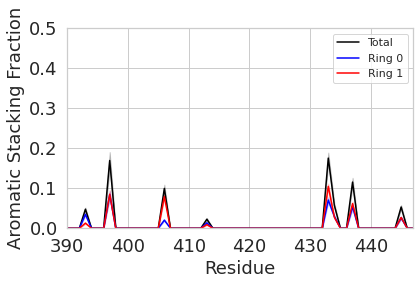

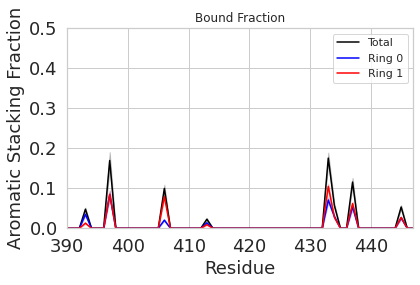

In [47]:
# Cast aromatic contacts as per residue in each frame
residues = 58
residue_offset = 390
residue_number = range(residue_offset, residue_offset+residues)
aro_res_index = np.array(prot_ring_index)-residue_offset

aromatic_stacking_contacts_r0 = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1 = np.zeros((n_frames, residues))
aromatic_stacking_contacts = np.zeros((n_frames, residues))

aromatic_contacts_r0 = np.zeros((n_frames, residues))
aromatic_contacts_r1 = np.zeros((n_frames, residues))
aromatic_contacts = np.zeros((n_frames, residues))

# print(aro_res_index)

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.0'][:, i]
    aromatic_contacts_r0[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.0'][:, i]

    aromatic_stacking_contacts_r1[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.1'][:, i]
    aromatic_contacts_r1[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.1'][:, i]

    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.0'][:, i]
    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.1'][:, i]

    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.0'][:, i]
    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.1'][:, i]


np.savetxt(outdir+'aromatic_stacking.traj.dat',
           aromatic_stacking_contacts, '%i')
aro_ave, aro_pyb_be = get_blockerrors_pyblock(aromatic_stacking_contacts, 1.0)
aro_by_res = np.column_stack((residue_number_offset, aro_ave, aro_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.be.dat', aro_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r0.dat',
           aromatic_stacking_contacts_r0, '%i')
aro_r0_ave, aro_r0_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r0, 1.0)
aro_r0_by_res = np.column_stack(
    (residue_number_offset, aro_r0_ave, aro_r0_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r0.be.dat', aro_r0_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r1.dat',
           aromatic_stacking_contacts_r1, '%i')
aro_r1_ave, aro_r1_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r1, 1.0)
aro_r1_by_res = np.column_stack(
    (residue_number_offset, aro_r1_ave, aro_r1_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r1.be.dat', aro_r1_by_res)


plt.plot(aro_by_res[:, 0], aro_by_res[:, 1], color='black', label='Total')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]+aro_by_res[:, 2],
                 aro_by_res[:, 1]-aro_by_res[:, 2], color='black', alpha=0.2)

plt.plot(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1],
         label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1]+aro_r0_by_res[:, 2],
                 aro_r0_by_res[:, 1]-aro_r0_by_res[:, 2], alpha=0.2, color='blue')

plt.plot(aro_r1_by_res[:, 0], aro_r1_by_res[:, 1], label='Ring 1', color='red')
plt.fill_between(aro_r1_by_res[:, 0], aro_r1_by_res[:, 1]+aro_r1_by_res[:, 2],
                 aro_r1_by_res[:, 1]-aro_r1_by_res[:, 2], alpha=0.2, color='red')

plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.pdf')
plt.show()
plt.clf()


# Scale For Bound Faction
aro_by_res_bf = np.column_stack(
    (residue_number_offset, aro_ave/boundfrac, aro_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.be.dat', aro_by_res_bf)
aro_r0_by_res_bf = np.column_stack(
    (residue_number_offset, aro_r0_ave/boundfrac, aro_r0_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r0.be.dat', aro_r0_by_res_bf)
aro_r1_by_res_bf = np.column_stack(
    (residue_number_offset, aro_r1_ave/boundfrac, aro_r1_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r1.be.dat', aro_r1_by_res_bf)


plt.plot(aro_by_res_bf[:, 0], aro_by_res_bf[:, 1],
         color='black', label='Total')
plt.fill_between(aro_by_res_bf[:, 0], aro_by_res_bf[:, 1]+aro_by_res_bf[:, 2],
                 aro_by_res_bf[:, 1]-aro_by_res_bf[:, 2], color='black', alpha=0.2)

plt.plot(aro_r0_by_res_bf[:, 0],
         aro_r0_by_res_bf[:, 1], label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res_bf[:, 0], aro_r0_by_res_bf[:, 1]+aro_r0_by_res_bf[:, 2],
                 aro_r0_by_res_bf[:, 1]-aro_r0_by_res_bf[:, 2], alpha=0.2, color='blue')

plt.plot(aro_r1_by_res_bf[:, 0],
         aro_r1_by_res_bf[:, 1], label='Ring 1', color='red')
plt.fill_between(aro_r1_by_res_bf[:, 0], aro_r1_by_res_bf[:, 1]+aro_r1_by_res_bf[:, 2],
                 aro_r1_by_res_bf[:, 1]-aro_r1_by_res_bf[:, 2], alpha=0.2, color='red')


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.title("Bound Fraction")
plt.savefig(outdir+'AromaticStackingFraction.BoundFraction.pdf')
plt.show()


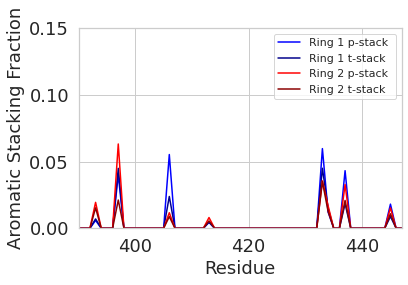

<Figure size 432x288 with 0 Axes>

In [48]:
# Cast aromatic contacts as per residue in each frame
residues = 58
residue_offset = 390
residue_number = range(residue_offset, residue_offset+residues)
aro_res_index = np.array(prot_ring_index)-residue_offset

aromatic_stacking_contacts_r0_p = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r0_t = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1_p = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1_t = np.zeros((n_frames, residues))

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0_p[:,
                                    aro_res_index[i]] = Pstack['Lig_ring.0'][:, i]
    aromatic_stacking_contacts_r1_p[:,
                                    aro_res_index[i]] = Pstack['Lig_ring.1'][:, i]
    aromatic_stacking_contacts_r0_t[:,
                                    aro_res_index[i]] = Tstack['Lig_ring.0'][:, i]
    aromatic_stacking_contacts_r1_t[:,
                                    aro_res_index[i]] = Tstack['Lig_ring.1'][:, i]

np.savetxt(outdir+'aromatic_pstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_p, '%i')
aromatic_pstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_p, axis=0)/trj.n_frames
np.savetxt(outdir+'aromatic_pstacking.traj.r1.dat',
           aromatic_stacking_contacts_r1_p, '%i')
aromatic_pstacking_fraction_r1 = np.sum(
    aromatic_stacking_contacts_r1_p, axis=0)/trj.n_frames

np.savetxt(outdir+'aromatic_tstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_t, '%i')
aromatic_tstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_t, axis=0)/trj.n_frames
np.savetxt(outdir+'aromatic_tstacking.traj.r1.dat',
           aromatic_stacking_contacts_r1_t, '%i')
aromatic_tstacking_fraction_r1 = np.sum(
    aromatic_stacking_contacts_r1_t, axis=0)/trj.n_frames


aromatic_by_res_r0_p = np.column_stack(
    (residue_number, aromatic_pstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_pstacking.fraction.r0.dat',
           aromatic_by_res_r0_p, fmt='%.4f')
aromatic_by_res_r0_t = np.column_stack(
    (residue_number, aromatic_tstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_tstacking.fraction.r0.dat',
           aromatic_by_res_r0_t, fmt='%.4f')
aromatic_by_res_r1_p = np.column_stack(
    (residue_number, aromatic_pstacking_fraction_r1/boundfrac))
np.savetxt(outdir+'aromatic_pstacking.fraction.r1.dat',
           aromatic_by_res_r1_p, fmt='%.4f')
aromatic_by_res_r1_t = np.column_stack(
    (residue_number, aromatic_tstacking_fraction_r1/boundfrac))
np.savetxt(outdir+'aromatic_tstacking.fraction.r1.dat',
           aromatic_by_res_r1_t, fmt='%.4f')


plt.plot(residue_number, aromatic_pstacking_fraction_r1,
         label='Ring 1 p-stack ', color='blue')
plt.plot(residue_number, aromatic_tstacking_fraction_r1,
         label='Ring 1 t-stack ', color='darkblue')
plt.plot(residue_number, aromatic_pstacking_fraction_r0,
         label='Ring 2 p-stack ', color='red')
plt.plot(residue_number, aromatic_tstacking_fraction_r0,
         label='Ring 2 t-stack ', color='darkred')

plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.15)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.p_vs_t.pdf')
plt.show()
plt.clf()


In [49]:
sidechains = len(prot_rings)
print(n_frames)
stack_distance_cutoff = 0.65
bound_fraction = boundfrac
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Ring_Contacts", "Stacked", "P-stacked", "T-stacked")
for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    theta = Stackparams['Lig_ring.0'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    phi = Stackparams['Lig_ring.0'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 45°.
    contacts = np.where(Stackparams['Lig_ring.0']
                        [name][:, 0] <= stack_distance_cutoff)
    b = np.where(newtheta[contacts] <= 45)
    c = np.where(newphi[contacts] <= 60)
    pstack = np.intersect1d(b, c)
    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
    # Here :  r < 6.0 Å, 75° < θ < 90° and ϕ < 15°.
    d = np.where(newtheta[contacts] >= 75)
    e = np.where(newphi[contacts] <= 60)
    tstack = np.intersect1d(d, e)
    print(name, res)
    arocontacts = len(contacts[0])/n_frames
    stacked = (len(pstack)+len(tstack))/n_frames
    pstacked = len(pstack)/n_frames
    tstacked = len(tstack)/n_frames
    print("Ring 0: %6.3lf %6.3lf %6.3lf %6.3lf" %
          (arocontacts, stacked, pstacked, tstacked))

    theta = Stackparams['Lig_ring.1'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    phi = Stackparams['Lig_ring.1'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 60°.
    contacts = np.where(Stackparams['Lig_ring.1']
                        [name][:, 0] <= stack_distance_cutoff)
    b = np.where(newtheta[contacts] <= 45)
    c = np.where(newphi[contacts] <= 60)
    pstack = np.intersect1d(b, c)
    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
    # Here :  r < 7.5 Å, 45° < θ and ϕ < 60°.
    d = np.where(newtheta[contacts] >= 75)
    e = np.where(newphi[contacts] <= 60)
    tstack = np.intersect1d(c, e)
    arocontacts = len(contacts[0])/n_frames
    stacked = (len(pstack)+len(tstack))/n_frames
    pstacked = len(pstack)/n_frames
    tstacked = len(tstack)/n_frames
    print("Ring 1: %6.3lf %6.3lf %6.3lf %6.3lf" %
          (arocontacts, stacked, pstacked, tstacked))


59747
Ring_Contacts Stacked P-stacked T-stacked
393 TYR3
Ring 0:  0.084  0.030  0.019  0.011
Ring 1:  0.024  0.023  0.006  0.017
397 TRP7
Ring 0:  0.208  0.077  0.063  0.014
Ring 1:  0.202  0.176  0.040  0.136
406 TYR16
Ring 0:  0.078  0.018  0.012  0.007
Ring 1:  0.207  0.223  0.055  0.168
413 HIS23
Ring 0:  0.034  0.012  0.008  0.004
Ring 1:  0.024  0.016  0.004  0.012
433 TRP43
Ring 0:  0.156  0.061  0.036  0.025
Ring 1:  0.230  0.213  0.060  0.153
434 HIS44
Ring 0:  0.083  0.025  0.017  0.008
Ring 1:  0.068  0.056  0.012  0.044
437 PHE47
Ring 0:  0.164  0.047  0.033  0.014
Ring 1:  0.201  0.144  0.043  0.101
445 TYR55
Ring 0:  0.058  0.023  0.015  0.007
Ring 1:  0.063  0.065  0.018  0.047


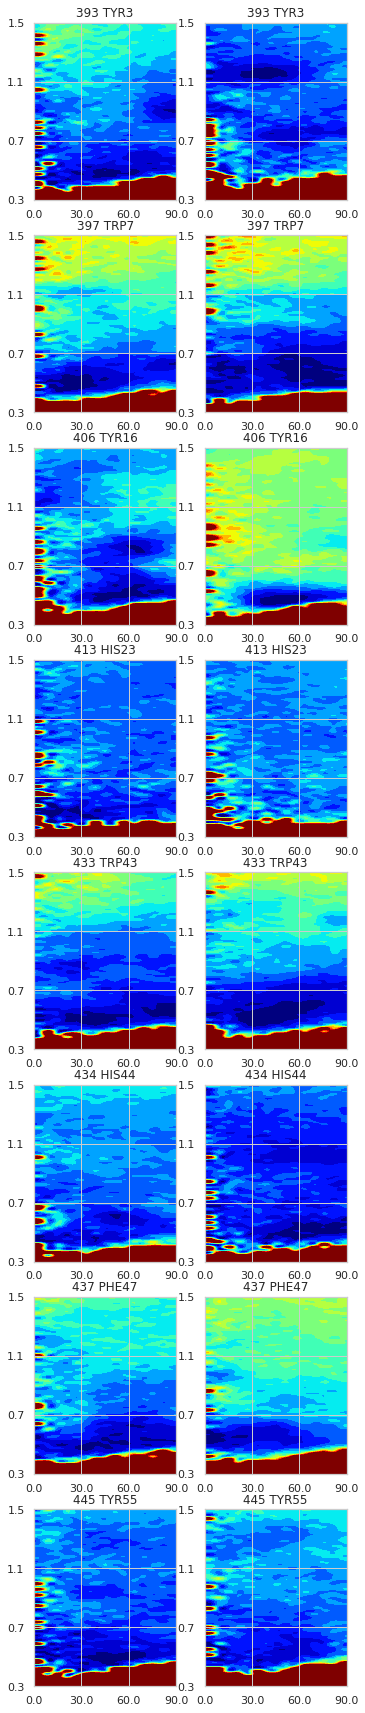

In [50]:
sidechains = len(prot_rings)
fig, ax = plt.subplots(sidechains, 2, figsize=(5.6, 30.6))

y0 = 0
ymax = 90.0
x0 = 0.3
xmax = 1.5
maxangle = ymax
maxdist = xmax
mindist = x0
minangle = y0

j = 0
name = prot_ring_index[j]
res = prot_ring_name[j]
theta = Stackparams['Lig_ring.0'][name][:, 3]
newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
d = Stackparams['Lig_ring.0'][name][:, 0]
a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                   y0, ymax]], normed=True, weights=None)
bin_centers_d = np.zeros((len(xedges)-1, len(yedges)-1))
bin_centers_theta = np.zeros((len(xedges)-1, len(yedges)-1))
norm = np.zeros((len(xedges)-1, len(yedges)-1))
kbT = 300*0.008314/4.184  # kT in kcal/mol

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        bin_centers_d[i-1, j-1] = (xedges[i-1]+xedges[i])/2
        bin_centers_theta[i-1, j-1] = (yedges[j-1]+yedges[j])/2

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        dist = bin_centers_d[i-1, j-1]
        thet = bin_centers_theta[i-1, j-1]
        norm[i-1, j-1] = np.sin(np.deg2rad(thet))*dist**2*a.sum()

for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    theta = Stackparams['Lig_ring.0'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    d = Stackparams['Lig_ring.0'][name][:, 0]
    a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                       y0, ymax]], normed=True, weights=None)

    kbT = 300*0.008314/4.184  # kT in kcal/mol
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 0].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 0].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 0].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 0].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 0].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)
    maxangle = ymax
    maxdist = xmax
    ax[j, 0].imshow(dG_norm, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    origin='lower', aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)

    theta = Stackparams['Lig_ring.1'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    d = Stackparams['Lig_ring.1'][name][:, 0]
    a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                       y0, ymax]], normed=True, weights=None)
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 1].imshow(dG_norm, extent=[0, maxangle, mindist, maxdist], origin='lower',
                    aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 1].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 1].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 1].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])

plt.savefig(outdir+'AromaticStackingFraction.RvTheta.pdf')
plt.show()


In [51]:
Stackparams['Lig_ring.1'][433][:, 4]


array([21.290, 37.933, 13.057, ..., 87.842, 74.219, 58.830])

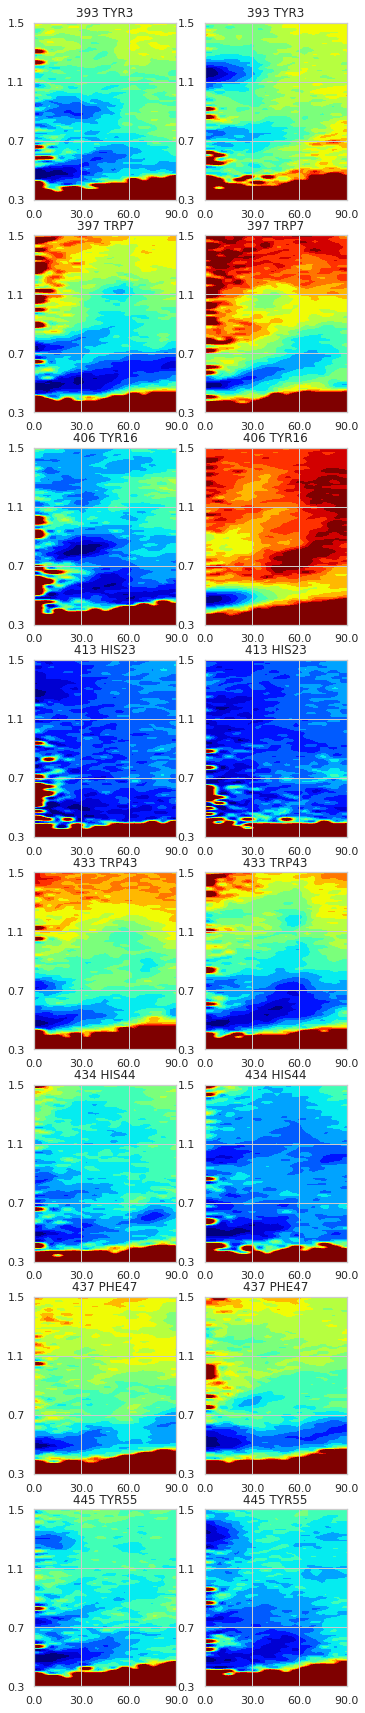

In [52]:
sidechains = len(prot_rings)
fig, ax = plt.subplots(sidechains, 2, figsize=(5.6, 30.6))

y0 = 0
ymax = 90.0
x0 = 0.3
xmax = 1.5
maxangle = ymax
maxdist = xmax
mindist = x0
minangle = y0

j = 0
name = prot_ring_index[j]
res = prot_ring_name[j]
phi = Stackparams['Lig_ring.0'][name][:, 4]
newphi = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(phi)-90.0)
d = Stackparams['Lig_ring.0'][name][:, 0]
a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                   y0, ymax]], normed=True, weights=None)
bin_centers_d = np.zeros((len(xedges)-1, len(yedges)-1))
bin_centers_theta = np.zeros((len(xedges)-1, len(yedges)-1))
norm = np.zeros((len(xedges)-1, len(yedges)-1))
kbT = 300*0.008314/4.184  # kT in kcal/mol

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        bin_centers_d[i-1, j-1] = (xedges[i-1]+xedges[i])/2
        bin_centers_theta[i-1, j-1] = (yedges[j-1]+yedges[j])/2

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        dist = bin_centers_d[i-1, j-1]
        thet = bin_centers_theta[i-1, j-1]
        norm[i-1, j-1] = np.sin(np.deg2rad(thet))*dist**2*a.sum()

for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    phi = Stackparams['Lig_ring.0'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    d = Stackparams['Lig_ring.0'][name][:, 0]
    a, xedges, yedges = np.histogram2d(
        d, newphi, [65, 15], [[x0, xmax], [y0, ymax]], normed=True, weights=None)

    kbT = 300*0.008314/4.184  # kT in kcal/mol
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 0].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 0].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 0].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 0].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 0].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)
    maxangle = ymax
    maxdist = xmax
    ax[j, 0].imshow(dG_norm, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    origin='lower', aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    phi = Stackparams['Lig_ring.1'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    d = Stackparams['Lig_ring.1'][name][:, 0]
    a, xedges, yedges = np.histogram2d(
        d, newphi, [65, 15], [[x0, xmax], [y0, ymax]], normed=True, weights=None)
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 1].imshow(dG_norm, extent=[0, maxangle, mindist, maxdist], origin='lower',
                    aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 1].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 1].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 1].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)

plt.savefig(outdir+'AromaticStackingFraction.RvPhi.pdf')
plt.show()


In [53]:
hbonds = print_donors_acceptors(
    trj[0], angle_cutoff=150, distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)


nh_donors [(6, 7), (25, 26), (37, 38), (58, 59), (65, 66), (76, 77), (86, 87), (96, 97), (110, 111), (120, 121), (130, 131), (140, 141), (150, 151), (160, 161), (172, 173), (172, 174), (240, 241), (253, 254), (256, 257), (256, 258), (259, 260), (259, 261), (264, 265), (285, 286), (292, 293), (304, 305), (323, 324), (333, 334), (344, 345), (363, 364), (374, 375), (380, 381), (387, 388), (397, 398), (404, 405), (414, 415), (424, 425), (445, 446), (452, 453), (463, 464), (470, 471), (495, 496), (506, 507), (516, 517), (526, 527), (536, 537), (547, 548), (558, 559), (569, 570), (579, 580), (593, 594), (604, 605), (610, 611), (624, 625), (643, 644), (663, 664), (677, 678), (687, 688), (702, 703), (717, 718), (724, 725), (736, 737), (736, 738), (741, 742), (760, 761), (781, 782), (788, 789), (788, 790)]
LEU1-N LEU1-H
ASP2-N ASP2-H
TYR3-N TYR3-H
GLY4-N GLY4-H
SER5-N SER5-H
ALA6-N ALA6-H
TRP7-N TRP7-H
TRP7-NE1 TRP7-HE1
ALA8-N ALA8-H
ALA9-N ALA9-H
ALA10-N ALA10-H
ALA11-N ALA11-H
ALA12-N ALA12-H

In [54]:
# Select Ligand Residues
ligand = top.select("residue 14 and not name N H CA HA CB HB1 HB2 C O")
# Select Protein Residues
protein = top.select("resid 0 to 13 or resid 15 to 57")


HBond_PD = np.zeros((n_frames, residues))
HBond_LD = np.zeros((n_frames, residues))
Hbond_pairs_PD = {}
Hbond_pairs_LD = {}


def add_hbond_pair(donor, acceptor, hbond_pairs, donor_res):
    if donor_res not in hbond_pairs:
        hbond_pairs[donor_res] = {}
    if donor not in hbond_pairs[donor_res]:
        hbond_pairs[donor_res][donor] = {}
    if acceptor not in hbond_pairs[donor_res][donor]:
        hbond_pairs[donor_res][donor][acceptor] = 0
    hbond_pairs[donor_res][donor][acceptor] += 1

# Donor & Acceptors Definitions from DESRES paper:
# ligdon = mol.select('chain B and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# ligacc = mol.select('chain B and (nitrogen or oxygen or sulfur)')
# protdon = mol.select('chain A and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# protacc = mol.select('chain A and (nitrogen or oxygen or sulfur)')


for frame in range(n_frames):
    hbonds = baker_hubbard2(trj[frame], angle_cutoff=150,
                            distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)
    for hbond in hbonds:
        if ((hbond[0] in protein) and (hbond[2] in ligand)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc = top.atom(hbond[2])
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_PD[frame][donor_res] = 1
            add_hbond_pair(donor, acc, Hbond_pairs_PD, donor_res)
        if ((hbond[0] in ligand) and (hbond[2] in protein)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc_id = hbond[2]
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_LD[frame][acc_res] = 1
            add_hbond_pair(donor, acc, Hbond_pairs_LD, acc_res)


In [55]:
residues = 58
residue_offset = 390
residue_number = range(residue_offset, residue_offset+residues)

HB_Total = HBond_PD+HBond_LD
HB_Total_ave = np.mean(HB_Total, axis=0)


PD_ave = np.mean(HBond_PD, axis=0)
LD_ave = np.mean(HBond_LD, axis=0)
for i in Hbond_pairs_PD:
    print(i, i+residue_offset, Hbond_pairs_PD[i])

print("HBond_Ligand Donors")

for i in Hbond_pairs_LD:
    print(i, Hbond_pairs_LD[i])

np.savetxt(outdir+'Hbond.PD.traj.dat', HBond_PD, '%i')
np.savetxt(outdir+'Hbond.LD.traj.dat', HBond_LD, '%i')
np.savetxt(outdir+'Hbond.all.traj.dat', HB_Total, '%i')
hbond_by_res = np.column_stack((residue_number, HB_Total_ave))
hbond_by_res_PD = np.column_stack((residue_number, PD_ave))
hbond_by_res_LD = np.column_stack((residue_number, LD_ave))


HBond_PD_ave, HBond_PD_pyb_be = get_blockerrors_pyblock(HBond_PD, 1.0)
HBond_LD_ave, HBond_LD_pyb_be = get_blockerrors_pyblock(HBond_LD, 1.0)
HBond_ave, HBond_pyb_be = get_blockerrors_pyblock(HB_Total, 1.0)

Hbond_by_res = np.column_stack(
    (residue_number_offset, HBond_ave, HBond_pyb_be))
Hbond_by_res_bf = np.column_stack(
    (residue_number_offset, HBond_ave/boundfrac, HBond_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.be.dat', Hbond_by_res)
np.savetxt(outdir+'hbond_fraction.boundfraction.be.dat', Hbond_by_res_bf)


Hbond_by_res_LD = np.column_stack(
    (residue_number_offset, HBond_LD_ave, HBond_LD_pyb_be))
np.savetxt(outdir+'hbond_fraction.PD.be.dat', Hbond_by_res_LD)
Hbond_by_res_LD_bf = np.column_stack(
    (residue_number_offset, HBond_LD_ave/boundfrac, HBond_LD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_LD_bf)


Hbond_by_res_PD = np.column_stack(
    (residue_number_offset, HBond_PD_ave, HBond_PD_pyb_be))
np.savetxt(outdir+'hbond_fraction.LD.be.dat', Hbond_by_res_PD)
Hbond_by_res_PD_bf = np.column_stack(
    (residue_number_offset, HBond_PD_ave/boundfrac, HBond_PD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_PD_bf)


21 411 {SER21-N: {CYE14-SG: 69, CYE14-O1: 33, CYE14-O3: 40, CYE14-O4: 43, CYE14-O5: 31}, SER21-OG: {CYE14-O1: 62, CYE14-O4: 67, CYE14-O3: 32, CYE14-O5: 34, CYE14-O2: 8, CYE14-SG: 3}}
15 405 {ARG15-N: {CYE14-O1: 196, CYE14-O2: 20}, ARG15-NE: {CYE14-O1: 249, CYE14-O2: 33, CYE14-O3: 4, CYE14-O4: 7, CYE14-O5: 1, CYE14-SG: 40}, ARG15-NH1: {CYE14-O4: 23, CYE14-O3: 42, CYE14-O1: 130, CYE14-O5: 7, CYE14-O2: 7}, ARG15-NH2: {CYE14-O5: 5, CYE14-O3: 37, CYE14-SG: 40, CYE14-O1: 36, CYE14-O4: 8, CYE14-O2: 131}}
8 398 {ALA8-N: {CYE14-O3: 8, CYE14-O5: 5, CYE14-O4: 3, CYE14-O2: 11}}
11 401 {ALA11-N: {CYE14-O1: 84, CYE14-O5: 13, CYE14-O4: 9, CYE14-SG: 6, CYE14-O2: 9, CYE14-O3: 4}}
32 422 {SER32-N: {CYE14-O5: 26, CYE14-O4: 16, CYE14-O3: 10, CYE14-O1: 11, CYE14-SG: 20, CYE14-O2: 28}, SER32-OG: {CYE14-O5: 25, CYE14-O4: 47, CYE14-O1: 35, CYE14-O3: 13, CYE14-O2: 17, CYE14-SG: 1}}
33 423 {GLY33-N: {CYE14-O4: 34, CYE14-O3: 33, CYE14-O2: 8, CYE14-O5: 63, CYE14-O1: 127, CYE14-SG: 39}}
45 435 {THR45-OG1: {CYE14-O

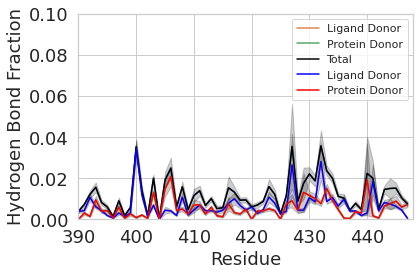

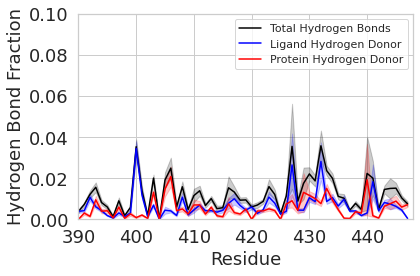

<Figure size 432x288 with 0 Axes>

In [56]:
residue_number = range(residue_offset, residue_offset+residues)
plt.plot(residue_number, HB_Total_ave)
plt.plot(residue_number, LD_ave, label="Ligand Donor")
plt.plot(residue_number, PD_ave, label="Protein Donor")


plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1], color='black', label='Total')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1],
         color='blue', label='Ligand Donor')
plt.fill_between(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1]+Hbond_by_res_LD[:, 2],
                 Hbond_by_res_LD[:, 1]-Hbond_by_res_LD[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1],
         color='red', label='Protein Donor')
plt.fill_between(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1]+Hbond_by_res_PD[:, 2],
                 Hbond_by_res_PD[:, 1]-Hbond_by_res_PD[:, 2], color='black', alpha=0.2)


plt.legend()
plt.ylim(0, 0.10)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.allframes.pdf')
plt.show()
plt.clf()


plt.plot(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1],
         color='black', label='Total Hydrogen Bonds')
plt.fill_between(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1]+Hbond_by_res_bf[:, 2],
                 Hbond_by_res_bf[:, 1]-Hbond_by_res_bf[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:,
         1], color='blue', label='Ligand Hydrogen Donor')
plt.fill_between(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:, 1]+Hbond_by_res_LD_bf[:, 2],
                 Hbond_by_res_LD_bf[:, 1]-Hbond_by_res_LD_bf[:, 2], color='blue', alpha=0.2)
plt.plot(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:,
         1], color='red', label='Protein Hydrogen Donor')
plt.fill_between(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:, 1]+Hbond_by_res_PD_bf[:, 2],
                 Hbond_by_res_PD_bf[:, 1]-Hbond_by_res_PD_bf[:, 2], color='red', alpha=0.2)


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.ylim(0, 0.10)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.boundfraction.pdf')
plt.show()
plt.clf()


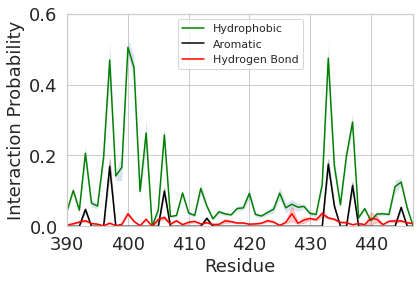

<Figure size 432x288 with 0 Axes>

In [57]:
plt.plot(residue_number_offset,
         hphob_by_res[:, 1], label='Hydrophobic', color='green')
plt.fill_between(residue_number_offset,
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.plot(aro_by_res[:, 0], aro_by_res[:, 1], color='black', label='Aromatic')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]+aro_by_res[:, 2],
                 aro_by_res[:, 1]-aro_by_res[:, 2], color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1],
         label='Hydrogen Bond', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='red', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.legend()
plt.tight_layout()
plt.savefig(outdir+'LigandInteractions.allframes.pdf')
plt.ylim(0, 0.6)
plt.show()
plt.clf()


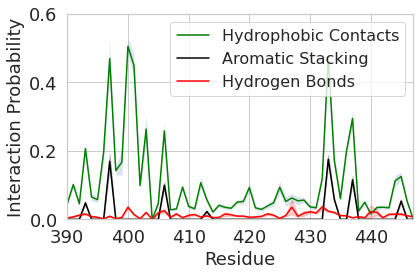

<Figure size 432x288 with 0 Axes>

In [58]:
plt.plot(residue_number_offset,
         hphob_by_res[:, 1]/boundfrac, label='Hydrophobic Contacts', color='green')
plt.fill_between(residue_number_offset, hphob_by_res[:, 1]/boundfrac+hphob_by_res[:, 2] /
                 boundfrac, hphob_by_res[:, 1]/boundfrac-hphob_by_res[:, 2]/boundfrac, alpha=0.2)

plt.plot(aro_by_res[:, 0], aro_by_res[:, 1]/boundfrac,
         color='black', label='Aromatic Stacking')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]/boundfrac+aro_by_res[:, 2]/boundfrac,
                 aro_by_res[:, 1]/boundfrac-aro_by_res[:, 2]/boundfrac, color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1] /
         boundfrac, label='Hydrogen Bonds', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]/boundfrac+Hbond_by_res[:, 2]/boundfrac,
                 Hbond_by_res[:, 1]/boundfrac-Hbond_by_res[:, 2]/boundfrac, color='red', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.6)
plt.legend(fontsize=16)
#plt.title("Bound Ensemble",size=18)
plt.tight_layout()
plt.savefig(outdir+'LigandInteractions.boundfraction.pdf')
plt.show()
plt.clf()


['ACE390', 'LEU391', 'ASP392', 'TYR393', 'GLY394', 'SER395', 'ALA396', 'TRP397', 'ALA398', 'ALA399', 'ALA400', 'ALA401', 'ALA402', 'GLN403', 'CYE404', 'ARG405', 'TYR406', 'GLY407', 'ASP408', 'LEU409', 'ALA410', 'SER411', 'LEU412', 'HIS413', 'GLY414', 'ALA415', 'GLY416', 'ALA417', 'ALA418', 'GLY419', 'PRO420', 'GLY421', 'SER422', 'GLY423', 'SER424', 'PRO425', 'SER426', 'ALA427', 'ALA428', 'ALA429', 'SER430', 'SER431', 'SER432', 'TRP433', 'HIS434', 'THR435', 'LEU436', 'PHE437', 'THR438', 'ALA439', 'GLU440', 'GLU441', 'GLY442', 'GLN443', 'LEU444', 'TYR445', 'GLY446', 'NH2447']
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


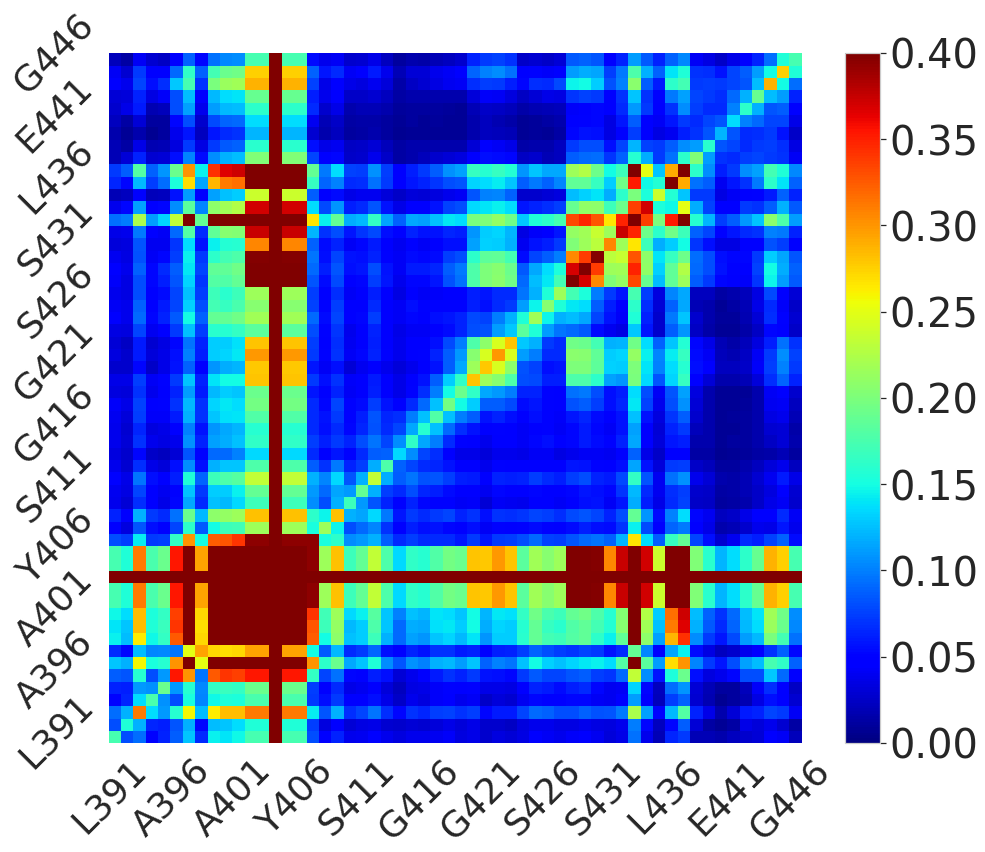

In [59]:
sequence = []
residue_offset = 390
for residue in trj.topology.residues:
    index = residue.index
    renum = int(index) + residue_offset
    sequence.append(residue.name + "%s" % (renum))
print(sequence)

# Make dual contact map
# This part can be commented once the dual_contact_map.dat is generated to save time
contact_maps = []
for i in range(1, 57):
    # print(i)
    contact_map = []
    for j in range(1, 57):
        if i == 14 or j == 14:
            contacts = 1
        else:
            dist1 = md.compute_contacts(trj, [[i, 14]], scheme='closest-heavy')
            dist2 = md.compute_contacts(trj, [[j, 14]], scheme='closest-heavy')
            array1 = np.asarray(dist1[0]).astype(float)
            array2 = np.asarray(dist2[0]).astype(float)
            contact1 = np.where(array1 < 0.6, 1, 0)
            contact2 = np.where(array2 < 0.6, 1, 0)
            sum = contact1 + contact2
            contact = np.where(sum == 2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    print(i)
    contact_maps.append(contact_map)
final_map = np.asarray(contact_maps).astype(float)
np.savetxt('%s/dual_contact_map.dat' % outdir, final_map, fmt='%1.3f')


sequence = ['L391', '', '', '', '', 'A396', '', '', '', '', 'A401', '', '', '', '', 'Y406', '', '', '', '', 'S411', '', '', '', '', 'G416',
            '', '', '', '', 'G421', '', '', '', '', 'S426', '', '', '', '', 'S431', '', '', '', '', 'L436', '', '', '', '', 'E441', '', '', '', '', 'G446']

final_map = np.loadtxt('%s/dual_contact_map.dat' % outdir)
# Make distance map
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
im = sns.heatmap(final_map, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
ax.tick_params(width = 3)
plt.xticks(range(57), sequence, rotation=45, size=36)
plt.yticks(range(1, 57), sequence, rotation=45, size=36)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=40)
cbar.set_clim(0, 0.45)
cbar.mappable.set_clim(0,0.4)
ax.invert_yaxis()
plt.tight_layout()

plt.savefig('%s/dual_contact_map.png' % outdir)
plt.savefig('%s/dual_contact_map.pdf' % outdir)
